##Importación del Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [4]:
from google.colab import files
files.upload() #this will prompt you to update the json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Saving in-vehicle-coupon-recommendation.csv to in-vehicle-coupon-recommendation (1).csv
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
#Search for datasets and competitions by name
!kaggle datasets list -s 'in-vehicle coupon recommendation'

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [6]:
#Download required dataset / competition files to a folder of your choice
!kaggle datasets download -d mathurinache/invehicle-coupon-recommendation -p /content/drive/My\ Drive/Aprendizaje Automático/Proyecto Final/dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


##Importación de Librerías

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

pd.set_option("display.max_columns", 50)

%matplotlib inline

##Revisión del Dataset

In [10]:
os.chdir('/content/')  #change dir

In [11]:
!ls

drive  in-vehicle-coupon-recommendation.csv  sample_data


In [13]:
#ruta
rutaDrive="/content/"
#Lectura del dataset
file_name = "in-vehicle-coupon-recommendation.csv"

#El método "read_csv" nos permite leer un excel
dataset = pd.read_csv(rutaDrive+file_name)

In [14]:
#Tamaño del dataset (registros, variables). En la nomenclatura de pandas es (axis 0, axis 1)
dataset.shape

(12684, 26)

In [15]:
#Vemos los primeros registros del dataset
dataset.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,NaN,never,never,NaN,4~8,1~3,1,1,0,0,1,0


In [16]:
dataset.isna().sum()/len(dataset)

destination             0.000000
passanger               0.000000
weather                 0.000000
temperature             0.000000
time                    0.000000
coupon                  0.000000
expiration              0.000000
gender                  0.000000
age                     0.000000
maritalStatus           0.000000
has_children            0.000000
education               0.000000
occupation              0.000000
income                  0.000000
car                     0.991485
Bar                     0.008436
CoffeeHouse             0.017108
CarryAway               0.011905
RestaurantLessThan20    0.010249
Restaurant20To50        0.014901
toCoupon_GEQ5min        0.000000
toCoupon_GEQ15min       0.000000
toCoupon_GEQ25min       0.000000
direction_same          0.000000
direction_opp           0.000000
Y                       0.000000
dtype: float64

##Pre-procesamiento del Dataset


In [17]:
def preprocess_dataset(dataset, save_metadata=True):
  preprocessed_dataset = dataset.copy()
  
  #Eliminamos la variable "toCoupon_GEQ5min"
  preprocessed_dataset.drop("toCoupon_GEQ5min", axis=1, inplace=True)

  #Eliminamos la variable "direction_same"
  preprocessed_dataset.drop("direction_same", axis=1, inplace=True)

  #Determinamos aquellas variables que tengan un porcentaje de registros nulos por cada variable mayor al valor de 0.7
  threshold = 0.7
  null_percentages = preprocessed_dataset.isna().sum() / len(preprocessed_dataset)
  criteria = null_percentages > threshold
  columns_to_filter = null_percentages[criteria].keys()

  #Eliminamos las variables seleccionadas en el paso anterior
  preprocessed_dataset.drop(columns_to_filter, axis=1, inplace=True)

  #Eliminamos los registros duplicados
  preprocessed_dataset.drop_duplicates(keep="first", inplace=True)

  #Determinamos que variables son del tipo númerico y cuales son categóricas
  numeric_columns = list()
  categorical_columns = list()
  dictionary_of_columns_with_index_to_categorical = dict()
  dictionary_of_columns_with_categorical_to_index = dict()

  for column in preprocessed_dataset:
      #Determinamos si la variable es numérica o no
      if pd.api.types.is_numeric_dtype(preprocessed_dataset[column]):
        numeric_columns.append(column)
      else:
        #Modificamos el tipo de dato de la variable mediante "astype"
        preprocessed_dataset[column] = preprocessed_dataset[column].astype("category")

        #Verificamos si el tipo de dato de la variable fue transformado a categórico correctamente
        if not pd.api.types.is_categorical_dtype(preprocessed_dataset[column]):
          raise Exception("La columna {} no se transformó correctamente a categórica".format(column))

        dictionary_of_columns_with_index_to_categorical[column] = dict()
        dictionary_of_columns_with_categorical_to_index[column] = dict()
        
        #Indexamos los valores (categorías), sin tomar en consideración los nulos, de la variable y guardamos esa información en los diccionarios
        for index, category in enumerate(preprocessed_dataset[column].cat.categories):
          dictionary_of_columns_with_index_to_categorical[column][index] = category
          dictionary_of_columns_with_categorical_to_index[column][category] = index
        
        categorical_columns.append(column)
    
  #Reemplazamos los nulos con la mediana sólo de aquellas variables numéricas
  median_of_numeric_columns = preprocessed_dataset[numeric_columns].median()

  preprocessed_dataset[numeric_columns] = preprocessed_dataset[numeric_columns].fillna(median_of_numeric_columns)

  #Transformamos a números los valores (categorías) de las variables categóricas sin considerar los nulos
  preprocessed_dataset.replace(dictionary_of_columns_with_categorical_to_index, inplace=True)

  #Generamos una nueva lista de variables categóricas y las variables eliminadas por tener un porcentaje alto de registros nulos
  categorical_columns_filtered = categorical_columns[:]
  
  if len(categorical_columns_filtered) > 0:
    #Reemplazamos los nulos con la mediana para todas las variables y las variables eliminadas por tener un porcentaje alto de registros nulos
    median_of_categorical_columns = preprocessed_dataset[categorical_columns_filtered].median()

    preprocessed_dataset[categorical_columns_filtered] = preprocessed_dataset[categorical_columns_filtered].fillna(median_of_categorical_columns)
  
  if save_metadata:
    #Guardamos información que consideremos imporante. El formato pickle nos permite guardar objetos de python
    with open("numeric_columns.pkl", "wb") as f:
      pickle.dump(numeric_columns, f)
    
    with open("categorical_columns.pkl", "wb") as f:
      pickle.dump(categorical_columns, f)
    
    with open("dictionary_of_columns_with_index_to_categorical.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_index_to_categorical, f)
    
    with open("dictionary_of_columns_with_categorical_to_index.pkl", "wb") as f:
      pickle.dump(dictionary_of_columns_with_categorical_to_index, f)
      
  return preprocessed_dataset

In [18]:
#Preprocesamos los datos
preprocessed_dataset = preprocess_dataset(dataset)

In [19]:
#Guardamos nuestro dataset pre-procesado en formato pickle
preprocessed_dataset.to_pickle("preprocessed_dataset_in_vehicle_train.pkl")

In [20]:
preprocessed_dataset.shape

(12610, 23)

In [21]:
preprocessed_dataset.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,has_children,education,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_opp,Y
0,1,0,2,55,2,4,0,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,0,0,1,1
1,1,1,2,80,0,2,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,0,0,1,0
2,1,1,2,80,0,1,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,1
3,1,1,2,80,2,2,1,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,0
4,1,1,2,80,2,2,0,0,0,3,1,5,24,3,4.0,4.0,1.0,1.0,0.0,1,0,1,0


In [22]:
#Cargamos los datos previamente guardados
with open("numeric_columns.pkl", "rb") as f:
    numeric_columns = pickle.load(f)

with open("categorical_columns.pkl", "rb") as f:
  categorical_columns = pickle.load(f)

with open("dictionary_of_columns_with_index_to_categorical.pkl", "rb") as f:
  dictionary_of_columns_with_index_to_categorical = pickle.load(f)

with open("dictionary_of_columns_with_categorical_to_index.pkl", "rb") as f:
  dictionary_of_columns_with_categorical_to_index = pickle.load(f)

preprocessed_dataset = pd.read_pickle("preprocessed_dataset_in_vehicle_train.pkl")

In [23]:
categorical_columns

['destination',
 'passanger',
 'weather',
 'time',
 'coupon',
 'expiration',
 'gender',
 'age',
 'maritalStatus',
 'education',
 'occupation',
 'income',
 'Bar',
 'CoffeeHouse',
 'CarryAway',
 'RestaurantLessThan20',
 'Restaurant20To50']

In [24]:
dictionary_of_columns_with_index_to_categorical["passanger"]

{0: 'Alone', 1: 'Friend(s)', 2: 'Kid(s)', 3: 'Partner'}

##Visualizamos la data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

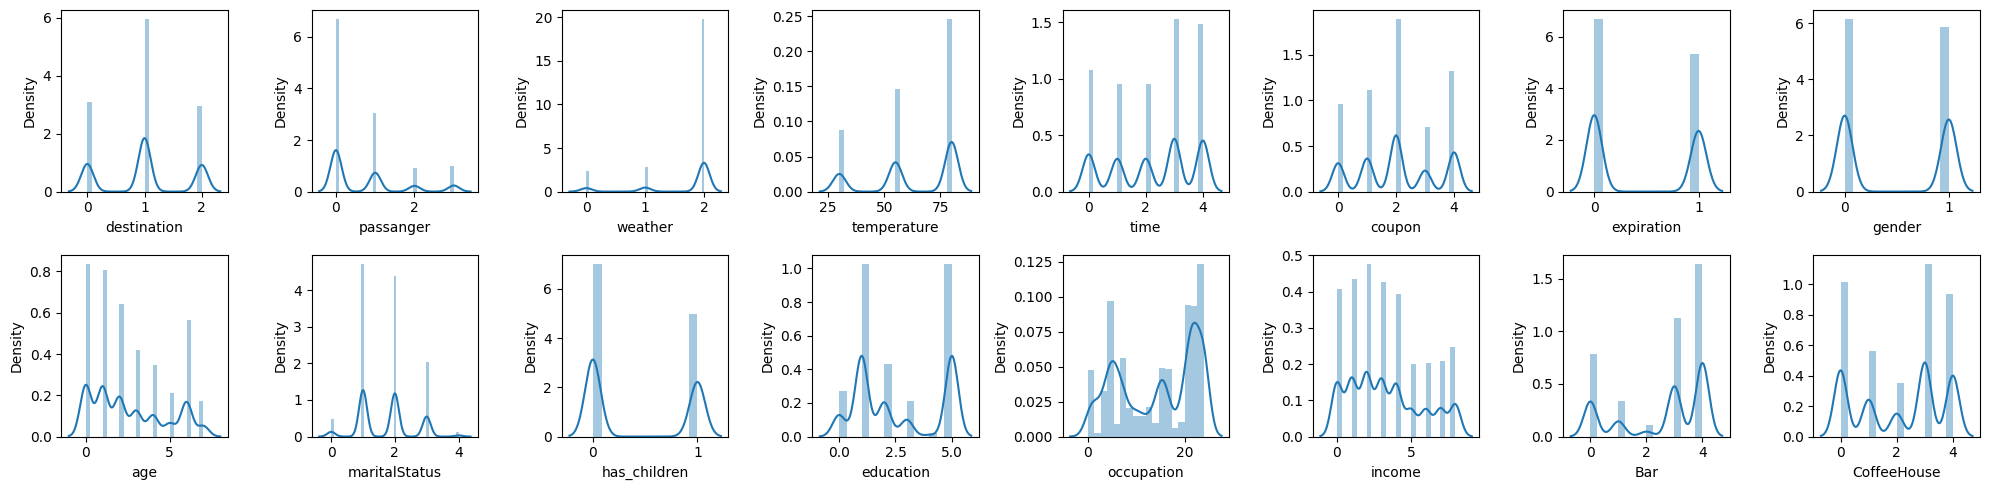

In [26]:
width = 20
height = 5

plt.style.use("default")

figure, axes = plt.subplots(nrows=2, ncols=8, figsize=(width, height))

for column, axe in zip(preprocessed_dataset, axes.flatten()):
    sns.distplot(preprocessed_dataset[column], ax=axe)
    
plt.tight_layout()

## Dividimos la data

In [27]:
#Separamos la data, en variables independientes (x) y dependientes (y), para poder entrenar un árbol de clasificación
x = preprocessed_dataset.drop("Y", axis=1)
y = preprocessed_dataset["Y"]

In [28]:
#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [29]:
print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

Train shape: (10088, 22)
Test shape: (2522, 22)


##Entrenamiento

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

tree_model=DecisionTreeClassifier(max_depth=5, random_state=17)
knn_model=KNeighborsClassifier(n_neighbors=10)

#entrenamos tree model
tree_model.fit(x_train, y_train)

#para KNN transformamos a escalar

scaler=StandardScaler()

x_train_scaler=scaler.fit_transform(x_train)
x_test_scaler=scaler.fit_transform(x_test)

knn_model.fit(x_train_scaler, y_train)




KNeighborsClassifier(n_neighbors=10)

In [35]:
#Precisión para decisición Tree clasifier
tree_predic=tree_model.predict(x_test)

accuracy_score(y_test, tree_predic)


0.6780333068992863

In [38]:
#precisión para KNN
knn_predic=knn_model.predict(x_test);
accuracy_score(y_test, knn_predic)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.5622521808088818

Ahora, identifiquemos los parámetros para el árbol mediante la validación cruzada. Ajustaremos la profundidad máxima y la cantidad máxima de funciones utilizadas en cada división. Aquí está la esencia de cómo funciona GridSearchCV: para cada par único de valores de max_ depth y max_features, calcule el rendimiento del modelo con una validación cruzada de 5 veces y luego seleccione la mejor combinación de parámetros.

In [40]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params={"max_depth": range(1,11), "max_features": range(4, 19)}

tree_grid=GridSearchCV(tree_model, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(x_train, y_train)


Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [41]:
tree_grid.best_params_

{'max_depth': 9, 'max_features': 16}

In [42]:
#score 
tree_grid.best_score_

0.6982557576752214

In [43]:
#acuracy de grid
tree_grid_predic = tree_grid.predict(x_test)
accuracy_score(y_test, tree_grid_predic)

0.6958762886597938

##Dibujamos el arbol de decisión

In [46]:
tree_grid.classes_

array([0, 1])

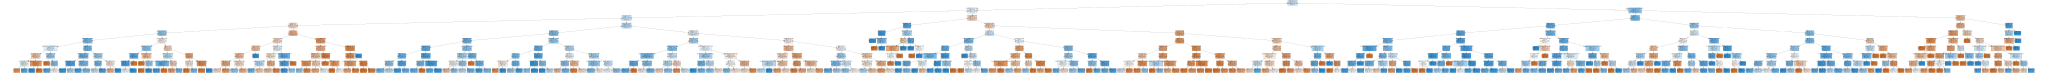

In [48]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

classes = [(str(model_class) if isinstance(model_class, np.integer) else model_class) for model_class in tree_grid.classes_]

graph = Source(export_graphviz(tree_grid.best_estimator_, feature_names = x.columns, class_names = classes, filled = True))

SVG(graph.pipe(format="svg"))

# Ahora con KNN

In [49]:
from sklearn.pipeline import Pipeline

knn_pipe=Pipeline(
    [("scaler", StandardScaler()),("knn", KNeighborsClassifier(n_jobs=-1))]
)

knn_params = {"knn__n_neighbors": range(1, 10)}

knn_grid=GridSearchCV(knn_pipe,knn_params,cv=5, n_jobs=-1, verbose=True)

knn_grid.fit(x_train, y_train)



Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 10)},
             verbose=True)

In [50]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 7}, 0.6545394867118098)

In [51]:
knn_grid_predic=knn_grid.predict(x_test)

print("Accuracy: ", accuracy_score(y_test, knn_grid_predic))

Accuracy:  0.6558287073750991


El árbol de decisión varia de precisión 67.8% 69.8% con validación cruzda. mientras tanto KNN tiene una gran variación tambien que es de 56.22% hasta 65.58% con validación cruzada.

In [52]:
#entrenamos con random forest

from sklearn.ensemble import RandomForestClassifier

forest_model= RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=17)

print(np.mean(cross_val_score(forest_model, x_train, y_train, cv=5)))

0.7389950534431564


In [53]:
forest_params = {"max_depth": range(6, 12), "max_features": range(4, 19)}

forest_grid = GridSearchCV(forest_model, forest_params, cv=5, n_jobs=-1, verbose=True)

forest_grid.fit(x_train, y_train)


Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(6, 12),
                         'max_features': range(4, 19)},
             verbose=True)

In [54]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 11, 'max_features': 16}, 0.7441508328857831)

In [55]:
forest_grid_predic = forest_grid.predict(x_test)

accuracy_score(y_test, forest_grid_predic)

0.7482157018239493

#resultados

In [57]:
print("CART Clasification", classification_report(y_test, tree_predic))

CART Clasification               precision    recall  f1-score   support

           0       0.63      0.61      0.62      1091
           1       0.71      0.73      0.72      1431

    accuracy                           0.68      2522
   macro avg       0.67      0.67      0.67      2522
weighted avg       0.68      0.68      0.68      2522



In [58]:
print("Grid Search model - clasificación", classification_report(y_test, tree_grid_predic))

Grid Search model - clasificación               precision    recall  f1-score   support

           0       0.66      0.63      0.64      1091
           1       0.72      0.75      0.74      1431

    accuracy                           0.70      2522
   macro avg       0.69      0.69      0.69      2522
weighted avg       0.69      0.70      0.69      2522



In [59]:
print("KNN ", classification_report(y_test, knn_predic))

KNN                precision    recall  f1-score   support

           0       0.49      0.42      0.45      1091
           1       0.60      0.67      0.64      1431

    accuracy                           0.56      2522
   macro avg       0.55      0.54      0.54      2522
weighted avg       0.55      0.56      0.56      2522



In [60]:
print("Grid Search model - knn", classification_report(y_test, knn_grid_predic))

Grid Search model - knn               precision    recall  f1-score   support

           0       0.62      0.54      0.58      1091
           1       0.68      0.74      0.71      1431

    accuracy                           0.66      2522
   macro avg       0.65      0.64      0.64      2522
weighted avg       0.65      0.66      0.65      2522



In [61]:
print("Grid Search model - random forest", classification_report(y_test, forest_grid_predic))

Grid Search model - random forest               precision    recall  f1-score   support

           0       0.75      0.63      0.68      1091
           1       0.75      0.84      0.79      1431

    accuracy                           0.75      2522
   macro avg       0.75      0.73      0.74      2522
weighted avg       0.75      0.75      0.74      2522

